# Implement EM Algorithm
## Plotting geyser dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv("./data.txt", sep=r"\s+", engine="python",header=0)
df.head()

,id,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


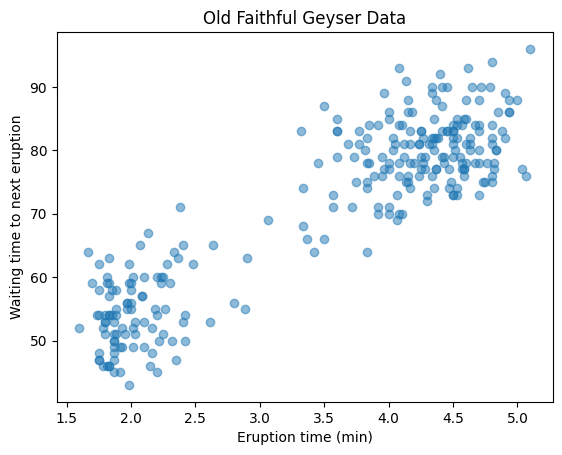

In [3]:
import matplotlib.pyplot as plt
plt.scatter(df['eruptions'], df['waiting'], alpha=0.5)
plt.xlabel('Eruption time (min)')
plt.ylabel('Waiting time to next eruption')
plt.title('Old Faithful Geyser Data')
plt.show()

## Implement and run EM algorithm
### E and M steps
I implemented the E and M steps from scratch for k=2.

In [19]:
import numpy as np
from scipy.stats import multivariate_normal

def E_step(D, mean_1, cov_1, phi_1, mean_2, cov_2, phi_2):
    eps = 1e-6
    cov_1_reg = cov_1 + eps * np.eye(D.shape[1])
    cov_2_reg = cov_2 + eps * np.eye(D.shape[1])
    
    probs_1 = multivariate_normal.pdf(D, mean=mean_1, cov=cov_1_reg, allow_singular=True) * phi_1
    probs_2 = multivariate_normal.pdf(D, mean=mean_2, cov=cov_2_reg, allow_singular=True) * phi_2

    total = probs_1 + probs_2 + 1e-12 

    posterior_1 = probs_1 / total
    posterior_2 = probs_2 / total

    return posterior_1, posterior_2

In [65]:
def M_step(D, posterior_1, posterior_2):
    eps = 1e-6
    n_1 = max(np.sum(posterior_1), 1e-6)
    n_2 = max(np.sum(posterior_2), 1e-6)

    # mu
    mean_1 = posterior_1 @ D / n_1
    mean_2 = posterior_2 @ D / n_2

    # sigma
    diff_1 = D - mean_1
    diff_2 = D - mean_2

    R1 = np.diag(posterior_1)
    R2 = np.diag(posterior_2)

    sigma_1 = diff_1.T @ R1 @ diff_1 / n_1
    sigma_2 = diff_2.T @ R2 @ diff_2 / n_2

    sigma_1 += eps * np.eye(D.shape[1])
    sigma_2 += eps * np.eye(D.shape[1])

    # phi
    phi_1 = n_1 / (n_1 + n_2)
    phi_2 = n_2 / (n_1 + n_2)

    return mean_1, sigma_1, phi_1, mean_2, sigma_2, phi_2


### Termination conditions
I will continue the algorithm based on the validation log likelihood. I will split the training set into a 80-20 split into train and validation. I will use the elbow method on the validation log likelihood graph over time.

In [66]:
# split data
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, test_size=0.2, random_state=5
)
print(df_train.shape, df_test.shape)


(217, 3) (55, 3)


In [67]:
# remove id column
D_train = df_train[['eruptions', 'waiting']].to_numpy()
D_test = df_test[['eruptions', 'waiting']].to_numpy()

In [77]:
# Initialize gaussian distributions
np.random.seed(5)

mean_1 = D_train[np.random.choice(D_train.shape[0])]
cov_1 = np.random.rand(2, 2)
cov_1 = cov_1 @ cov_1.T  # make it symmetric positive definite
phi_1 = np.random.rand()

mean_2 = D_train[np.random.choice(D_train.shape[0])]
cov_2 = np.random.rand(2, 2)
cov_2 = cov_2 @ cov_2.T  # make it symmetric positive definite
phi_2 = 1 - phi_1
print(mean_1, cov_1, phi_1)
print(mean_2, cov_2, phi_2)

[ 1.75 47.  ] [[0.69415081 0.83431094]
 [0.83431094 1.09161704]] 0.08982103773760686
[ 4.933 86.   ] [[0.85537205 0.3246399 ]
 [0.3246399  0.1233298 ]] 0.9101789622623931


In [78]:
print("D_train shape:", D_train.shape)
print("D_test shape:", D_test.shape)
print("mean_1 shape:", mean_1.shape)
print("mean_2 shape:", mean_2.shape)
print("cov_1 shape:", cov_1.shape)
print("cov_2 shape:", cov_2.shape)

D_train shape: (217, 2)
D_test shape: (55, 2)
mean_1 shape: (2,)
mean_2 shape: (2,)
cov_1 shape: (2, 2)
cov_2 shape: (2, 2)


In [79]:
# Run EM algorithm
def run_EM(D_train, D_test, mean_1, cov_1, phi_1, mean_2, cov_2, phi_2, max_iters=100):
    log_likelihoods = []
    means_1_list = [mean_1.copy()]
    means_2_list = [mean_2.copy()]
    eps = 1e-6

    # Code adapted from ChatGPT (OpenAI 2025)
    for i in range(max_iters):
        # E-step
        posterior_1, posterior_2 = E_step(D_train, mean_1, cov_1, phi_1, mean_2, cov_2, phi_2)

        # M-step
        mean_1, cov_1, phi_1, mean_2, cov_2, phi_2 = M_step(D_train, posterior_1, posterior_2)

        # Compute log-likelihood
        ll_1 = multivariate_normal.pdf(D_test, mean=mean_1, cov=cov_1 + eps * np.eye(D_test.shape[1])) * phi_1
        ll_2 = multivariate_normal.pdf(D_test, mean=mean_2, cov=cov_2 + eps * np.eye(D_test.shape[1])) * phi_2
        log_likelihood = np.sum(np.log(ll_1 + ll_2 + 1e-12))
        log_likelihoods.append(log_likelihood)

        # Save means for analysis
        means_1_list.append(mean_1.copy())
        means_2_list.append(mean_2.copy())

        print(f"Iteration {i+1}, Log Likelihood: {log_likelihood:.6f}")
        if i > 0 and abs(log_likelihood - log_likelihoods[-2]) < 1e-5:
            break

    return mean_1, cov_1, phi_1, mean_2, cov_2, phi_2, log_likelihoods, means_1_list, means_2_list


In [80]:
mean_1, cov_1, phi_1, mean_2, cov_2, phi_2, log_likelihoods, means_1_list, means_2_list = run_EM(
    D_train, D_test,
    mean_1, cov_1, phi_1,
    mean_2, cov_2, phi_2,
    max_iters=100
)

Iteration 1, Log Likelihood: -1373.799228
Iteration 2, Log Likelihood: -1099.324766
Iteration 3, Log Likelihood: -961.680773
Iteration 4, Log Likelihood: -270.565657
Iteration 5, Log Likelihood: -257.186770
Iteration 6, Log Likelihood: -257.186438
Iteration 7, Log Likelihood: -257.186438


In [81]:
print(means_1_list)

[array([ 1.75, 47.  ]), array([ 1.93937086, 47.49746924]), array([ 1.99906204, 50.57189338]), array([ 2.07589857, 54.47415801]), array([ 2.91082821, 64.57408706]), array([ 3.44998344, 70.27105137]), array([ 3.44999032, 70.27112662]), array([ 3.44999033, 70.27112667])]


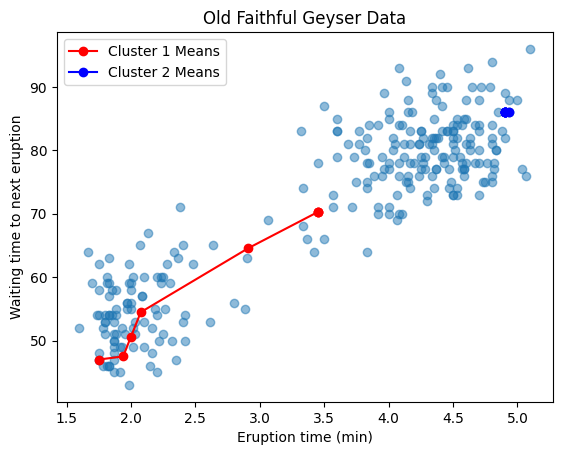

In [82]:
import matplotlib.pyplot as plt
import numpy as np

# Code adapted from ChatGPT (OpenAI 2025)
# Scatter plot of the data
plt.scatter(df['eruptions'], df['waiting'], alpha=0.5)
plt.xlabel('Eruption time (min)')
plt.ylabel('Waiting time to next eruption')
plt.title('Old Faithful Geyser Data')

# Convert your lists of means to arrays
means_1_array = np.vstack(means_1_list)  # shape (n_iters, 2)
means_2_array = np.vstack(means_2_list)  # shape (n_iters, 2)

# Plot the trajectory of cluster 1
plt.plot(means_1_array[:,0], means_1_array[:,1],
         marker='o', color='red', linestyle='-', label='Cluster 1 Means')

# Plot the trajectory of cluster 2
plt.plot(means_2_array[:,0], means_2_array[:,1],
         marker='o', color='blue', linestyle='-', label='Cluster 2 Means')

plt.legend()
plt.show()

### GMM can easily get stuck in local minima
As seen, the final clusters look very odd. For example, the red cluster 1 mean is in between the two clusters visually while the cluster 2 mean is in the edge of the upper right cluster. I think this is a local minima that was found in the GMM algorithm, so I reran the algorithm with a different initialization random seed.

In [74]:
# Initialize gaussian distributions
np.random.seed(6)

mean_1 = D_train[np.random.choice(D_train.shape[0])]
cov_1 = np.random.rand(2, 2)
cov_1 = cov_1 @ cov_1.T  # make it symmetric positive definite
phi_1 = np.random.rand()

mean_2 = D_train[np.random.choice(D_train.shape[0])]
cov_2 = np.random.rand(2, 2)
cov_2 = cov_2 @ cov_2.T  # make it symmetric positive definite
phi_2 = 1 - phi_1
print(mean_1, cov_1, phi_1)
print(mean_2, cov_2, phi_2)

[ 4.35 85.  ] [[0.94156194 0.13838297]
 [0.13838297 0.14110962]] 0.9850288152326052
[ 2.2 45. ] [[0.4561061  0.43842066]
 [0.43842066 0.50002887]] 0.014971184767394785


In [75]:
mean_1, cov_1, phi_1, mean_2, cov_2, phi_2, log_likelihoods, means_1_list, means_2_list = run_EM(
    D_train, D_test,
    mean_1, cov_1, phi_1,
    mean_2, cov_2, phi_2,
    max_iters=100
)

Iteration 1, Log Likelihood: -846.147703
Iteration 2, Log Likelihood: -300.933973
Iteration 3, Log Likelihood: -221.318760
Iteration 4, Log Likelihood: -218.988023
Iteration 5, Log Likelihood: -218.723442
Iteration 6, Log Likelihood: -218.768995
Iteration 7, Log Likelihood: -218.795848
Iteration 8, Log Likelihood: -218.804330
Iteration 9, Log Likelihood: -218.806560
Iteration 10, Log Likelihood: -218.807111
Iteration 11, Log Likelihood: -218.807245
Iteration 12, Log Likelihood: -218.807278
Iteration 13, Log Likelihood: -218.807285


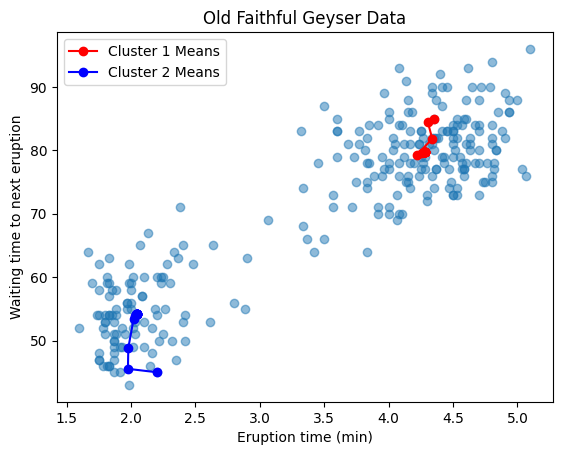

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Code adapted from ChatGPT (OpenAI 2025)
# Scatter plot of the data
plt.scatter(df['eruptions'], df['waiting'], alpha=0.5)
plt.xlabel('Eruption time (min)')
plt.ylabel('Waiting time to next eruption')
plt.title('Old Faithful Geyser Data')

# Convert your lists of means to arrays
means_1_array = np.vstack(means_1_list)  # shape (n_iters, 2)
means_2_array = np.vstack(means_2_list)  # shape (n_iters, 2)

# Plot the trajectory of cluster 1
plt.plot(means_1_array[:,0], means_1_array[:,1],
         marker='o', color='red', linestyle='-', label='Cluster 1 Means')

# Plot the trajectory of cluster 2
plt.plot(means_2_array[:,0], means_2_array[:,1],
         marker='o', color='blue', linestyle='-', label='Cluster 2 Means')

plt.legend()
plt.show()

## K means clustering
I predict that the K-means clusters would be very similar for K=2. This is because the two clusters are visually round and do not overlap very much. This means the clusters don't have too much covariance between the two feature dimensions, so K-means can still cluster well.

In [51]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=5)
kmeans.fit(df[['eruptions', 'waiting']].values)

,n_clusters,2
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,5
,copy_x,True
,algorithm,'lloyd'


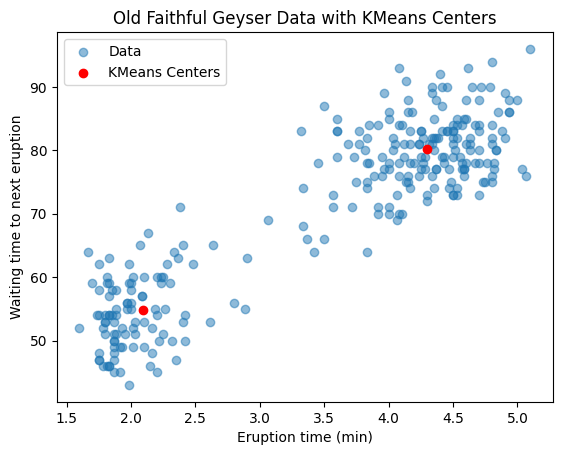

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Code adapted from ChatGPT (OpenAI 2025)
# Your data
X = df[['eruptions', 'waiting']].values

labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Scatter plot of the original data
plt.scatter(df['eruptions'], df['waiting'], alpha=0.5, label='Data')

# Overlay KMeans cluster centers
plt.scatter(centers[:,0], centers[:,1], color='red', label='KMeans Centers')

plt.xlabel('Eruption time (min)')
plt.ylabel('Waiting time to next eruption')
plt.title('Old Faithful Geyser Data with KMeans Centers')
plt.legend()
plt.show()


As seen, there is some similarity between the K-means clustering such that both clustering algorithms put one center at each of the two visual clusters. However, the exact center of the GMM clusters are more

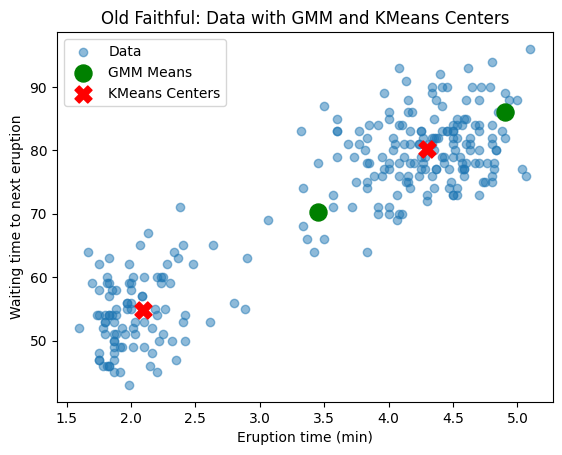

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Scatter plot of the data
plt.scatter(df['eruptions'], df['waiting'], alpha=0.5, label='Data')

# Plot final GMM means
gmm_means = np.vstack([means_1_list, means_2_list])
plt.scatter(gmm_means[:,0], gmm_means[:,1], color='green', marker='o', s=150, label='GMM Means')

# Plot KMeans centers
kmeans_centers = kmeans.cluster_centers_
plt.scatter(kmeans_centers[:,0], kmeans_centers[:,1], color='red', marker='X', s=150, label='KMeans Centers')

plt.xlabel('Eruption time (min)')
plt.ylabel('Waiting time to next eruption')
plt.title('Old Faithful: Data with GMM and KMeans Centers')
plt.legend()
plt.show()
